In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = 'FINAL_DATA.xlsx'
data = pd.read_excel(file_path)
# data.info()

In [3]:
#fill in missing values
data['crime_rate'].fillna(data['crime_rate'].median(), inplace=True)
data['0br_2019'].fillna(data['0br_2019'].median(), inplace=True)

#calculate rent growth rates to find rate for prediction
data['rent_growth_2019_2020'] = (data['0br_2020'] - data['0br_2019']) / data['0br_2019']
data['rent_growth_2020_2021'] = (data['0br_2021'] - data['0br_2020']) / data['0br_2020']
data['rent_growth_2021_2022'] = (data['0br_2022'] - data['0br_2021']) / data['0br_2021']
data['rent_growth_2022_2023'] = (data['0br_2023'] - data['0br_2022']) / data['0br_2022']
data['predicted_growth_2023_2024'] = data[['rent_growth_2019_2020', 'rent_growth_2020_2021', 'rent_growth_2021_2022', 'rent_growth_2022_2023']].mean(axis=1)

In [4]:
features = data[['0br_2019', '0br_2020', '0br_2021', '0br_2022', '0br_2023', 'predicted_growth_2023_2024']]
target = data['predicted_growth_2023_2024']
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

#Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

#Linear Regression 
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Gradient Boosting Regressor
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

rent_2024_predictions = gb.predict(features)
data['rent_2024'] = (data['0br_2023'] * (1+ rent_2024_predictions)).round()

mse = mean_squared_error(y_test, y_pred)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mse_gb = mean_squared_error(y_test, y_pred_gb)
print(f"Random Forest - Mean Squared Error: {mse}, Root Mean Squared Error: {np.sqrt(mse)}")
print(f"Linear Regression - Mean Squared Error: {mse_lr}, Root Mean Squared Error: {np.sqrt(mse_lr)}")
print(f"Gradient Boost - Mean Squared Error: {mse_gb}, Root Mean Squared Error: {np.sqrt(mse_gb)}")

Random Forest - Mean Squared Error: 9.756345486900447e-06, Root Mean Squared Error: 0.003123514925032446
Linear Regression - Mean Squared Error: 7.519151491211833e-33, Root Mean Squared Error: 8.671304106771849e-17
Gradient Boost - Mean Squared Error: 8.740090132353286e-06, Root Mean Squared Error: 0.002956364343641238


In [7]:
#Retraining the model without historical rent prices and new target variable.
exclude_features = ['0br_2019', '0br_2020', 'mean_rent','rent_growth_2019_2020', 'zip_code', '0br_2021', '0br_2022', '0br_2023', 'community', 'neighborhood', 'predicted_growth_2023_2024','rent_2024','rent_growth_2021_2022', 'rent_growth_2022_2023','rent_growth_2020_2021']
features_new = data.drop(columns=exclude_features)
target_new = data['rent_2024']
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features_new, target_new, test_size=0.2, random_state=42)
rf_2 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_2.fit(X_train_2, y_train_2)
feature_importance = rf_2.feature_importances_
importance_df = pd.DataFrame({'Feature': features_new.columns, 'Importance': feature_importance})
final_importance = importance_df.sort_values(by='Importance', ascending=False).head(10)
print(final_importance)

                    Feature  Importance
11        latino_population    0.548471
1   median_household_income    0.175143
3    average_household_size    0.069624
10         asian_population    0.041062
7          white_population    0.036690
6                median_age    0.024837
0                population    0.023099
8          black_population    0.020854
9         native_population    0.017233
2         unemployment_rate    0.016400


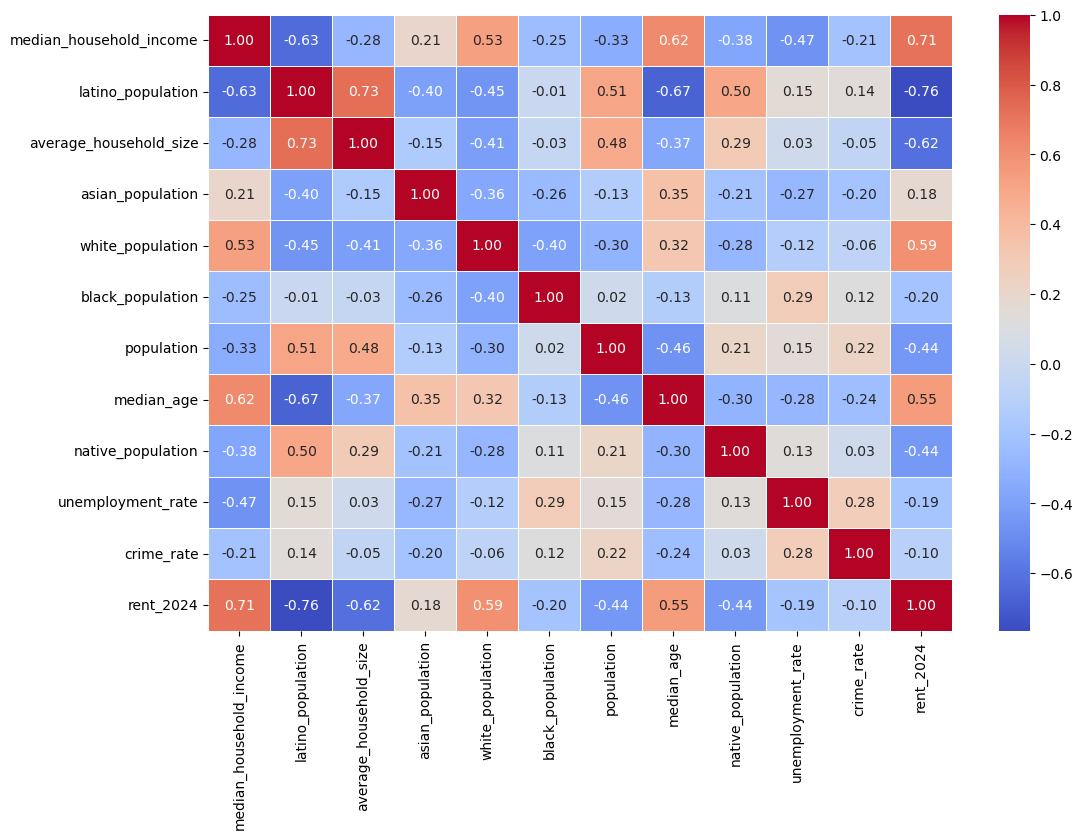

In [10]:
top_features = ['median_household_income', 'latino_population', 'average_household_size', 'asian_population', 'white_population', 'black_population', 'population', 'median_age', 'native_population', 'unemployment_rate', 'crime_rate', 'rent_2024']
correlation_matrix = data[top_features].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.show()

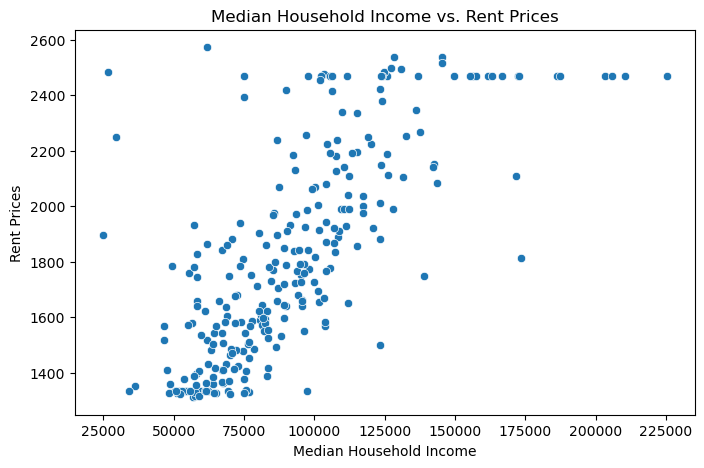

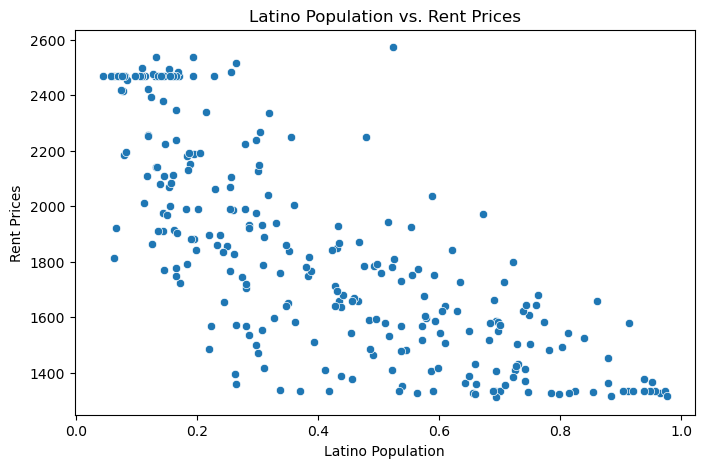

In [7]:
# Median Household Income vs. Rent Prices scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data['median_household_income'], y=data['rent_2024'])
plt.title('Median Household Income vs. Rent Prices')
plt.xlabel('Median Household Income')
plt.ylabel('Rent Prices')
plt.show()
# Latino Population vs. Rent Prices scatter plot
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data['latino_population'], y=data['rent_2024'])
plt.title('Latino Population vs. Rent Prices')
plt.xlabel('Latino Population')
plt.ylabel('Rent Prices')
plt.show()


Time Series Analysis

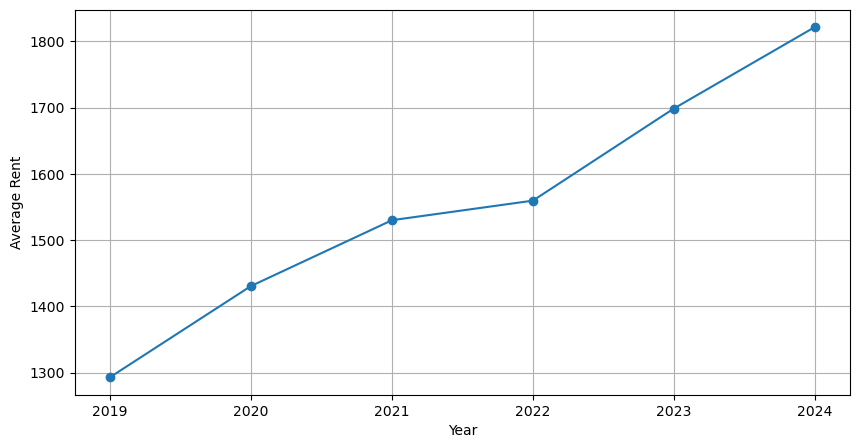

In [16]:
years = ['0br_2019', '0br_2020', '0br_2021', '0br_2022', '0br_2023', 'rent_2024']
time_series_data = pd.DataFrame(data[years].mean()).reset_index()
time_series_data.columns = ['Year', 'Average_Rent']
time_series_data['Year'] = time_series_data['Year'].apply(lambda x: x.split('_')[1]).astype(int)
time_series_data['Year'] = pd.to_datetime(time_series_data['Year'], format='%Y')
time_series_data.set_index('Year', inplace=True)
plt.figure(figsize=(10, 5))
plt.plot(time_series_data.index, time_series_data['Average_Rent'], marker='o')
plt.xlabel('Year')
plt.ylabel('Average Rent')
plt.grid(True)
plt.show()

In [12]:
data.to_csv('arcgis_data.csv')